# Set Parameters

In [ ]:
import cv2
import os, sys
import errno
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

in_image = "00000000.tif"
linesegments_location  = "./data/linesegments/"
ccs_location           = "./data/ccs/"
meta_location          = "./data/metadata/"

image_name, image_extension = os.path.splitext(in_image)

in_linesegments_name = "line"
in_cc_name           = "cc"
in_meta_name         = "metadata"

# Read Metadata

In [3]:
import json

file_metadata = open(os.path.join(meta_location,in_meta_name),"r")
str_metadata  = file_metadata.read()
json_metadata = json.loads(str_metadata)
h = int(json_metadata['height'])
w = int(json_metadata['width'])
json_metadata

{'IQR': '95',
 'Q1': '74',
 'Q3': '169',
 'angleMode': '0.8',
 'fileName': './data/binary/full_2.tiff',
 'height': '6094',
 'numOfCC': '38007',
 'numOfNoiseZone': '154',
 'numOfSites': '175436',
 'numOfZone': '207',
 'sizeMean': '124',
 'sizeStd': '184',
 'td1': '8',
 'td2': '32',
 'width': '4680',
 'zoneIQR': '14549.0',
 'zoneMax': '10202242',
 'zoneMean': '137777',
 'zoneMedian': '3765',
 'zoneMin': '58',
 'zoneQ1': '990.5',
 'zoneQ3': '15539.5',
 'zoneStd': '812332'}

# Generate Binary Voronoi-Edge Mask (BEM)

In this process, a binary mask representing Voronoi-edge is generated by following procedure:

- 1.Generate a canvas with a size of original image's witdh and height in which every pixel is initialized as 255.

  
- 2.Read Voronoi-edge information (e.g., [start_x, end_x, start_y, end_y]) and assign a pixel value of 0 to a corresponding location on the canvas.


13769it [00:00, 242522.39it/s]


<IPython.core.display.Javascript object>


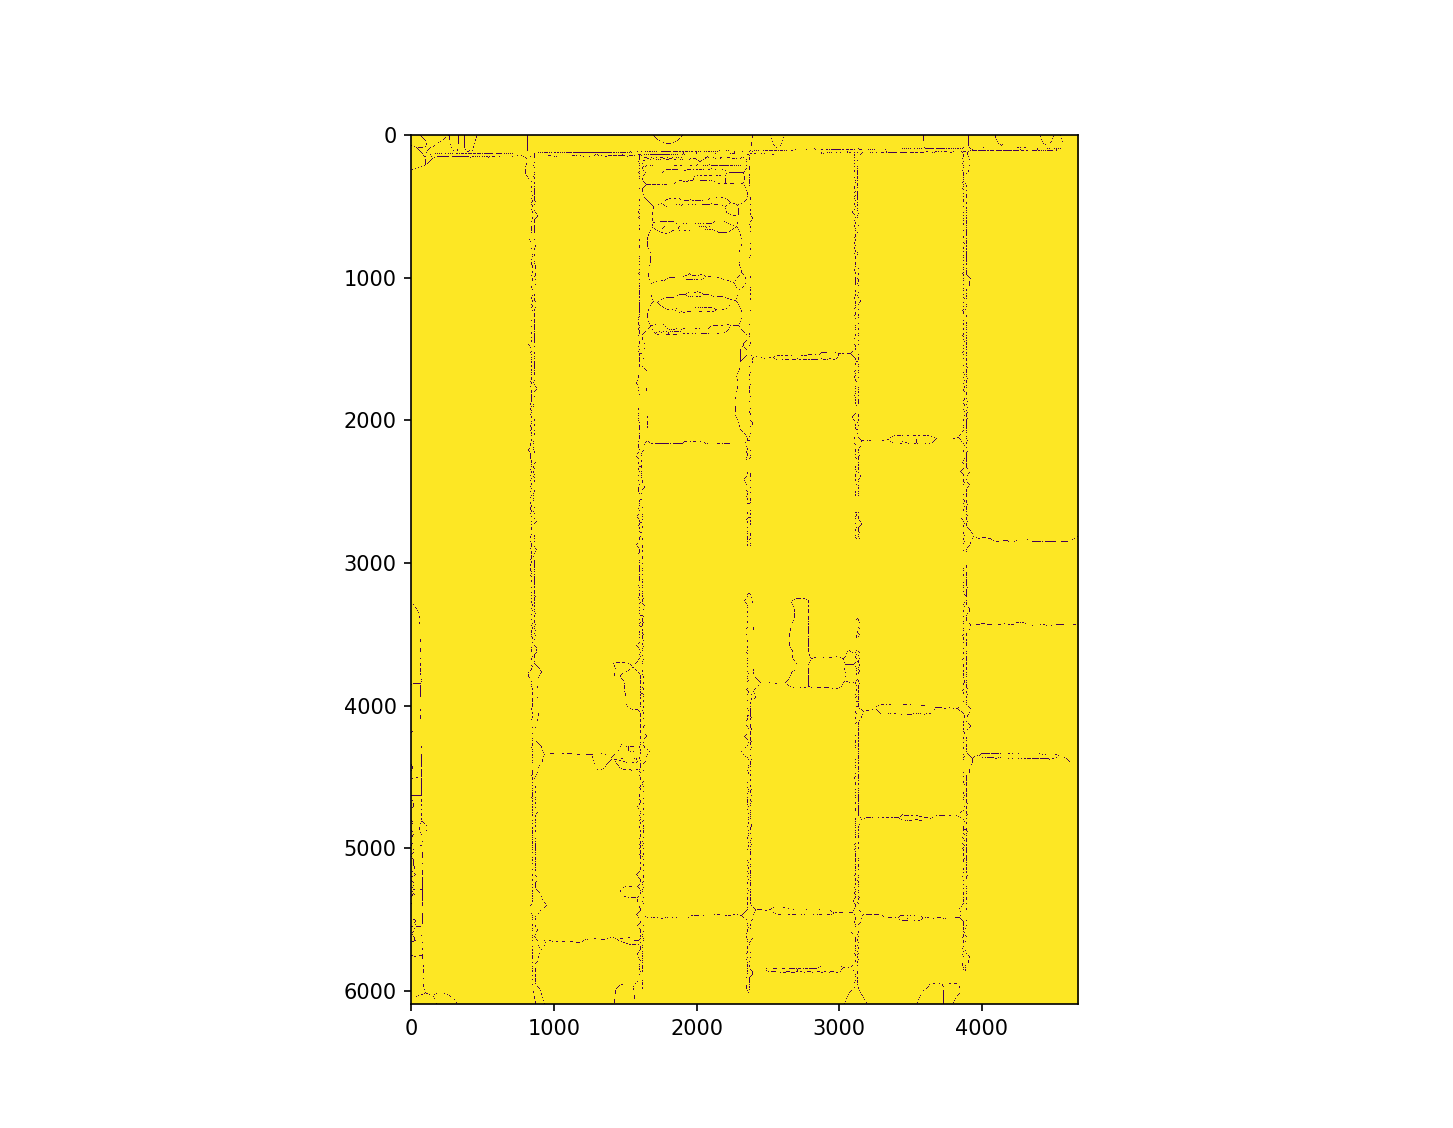

In [4]:
# read line segment info
file_linesegments = open(os.path.join(linesegments_location,in_linesegments_name),"r")

# voronoi-ridge mask
img_voronoi_mask = 255*np.ones([h,w])
for line in tqdm(file_linesegments): 
    # Parse coordinates
    cs,ce,rs,re = (int(x) for x in line.split())
    #print("({},{}) ({},{})".format(cs,rs,ce,re))
    # Draw line
    cv2.line(img_voronoi_mask,(cs,rs),(ce,re),(0,0,0),2)

%matplotlib notebook
plt.imshow(img_voronoi_mask)
plt.show()


# Find Connected-components from BEM

From the generated BEM, we find all connected components using opencv's built-in function. Note here that opencv document does not states the exact time-complexity of this built-in function, and we assume that it should not be worse than O(witdh*height) 

Total 206 region(s) are found.


<IPython.core.display.Javascript object>


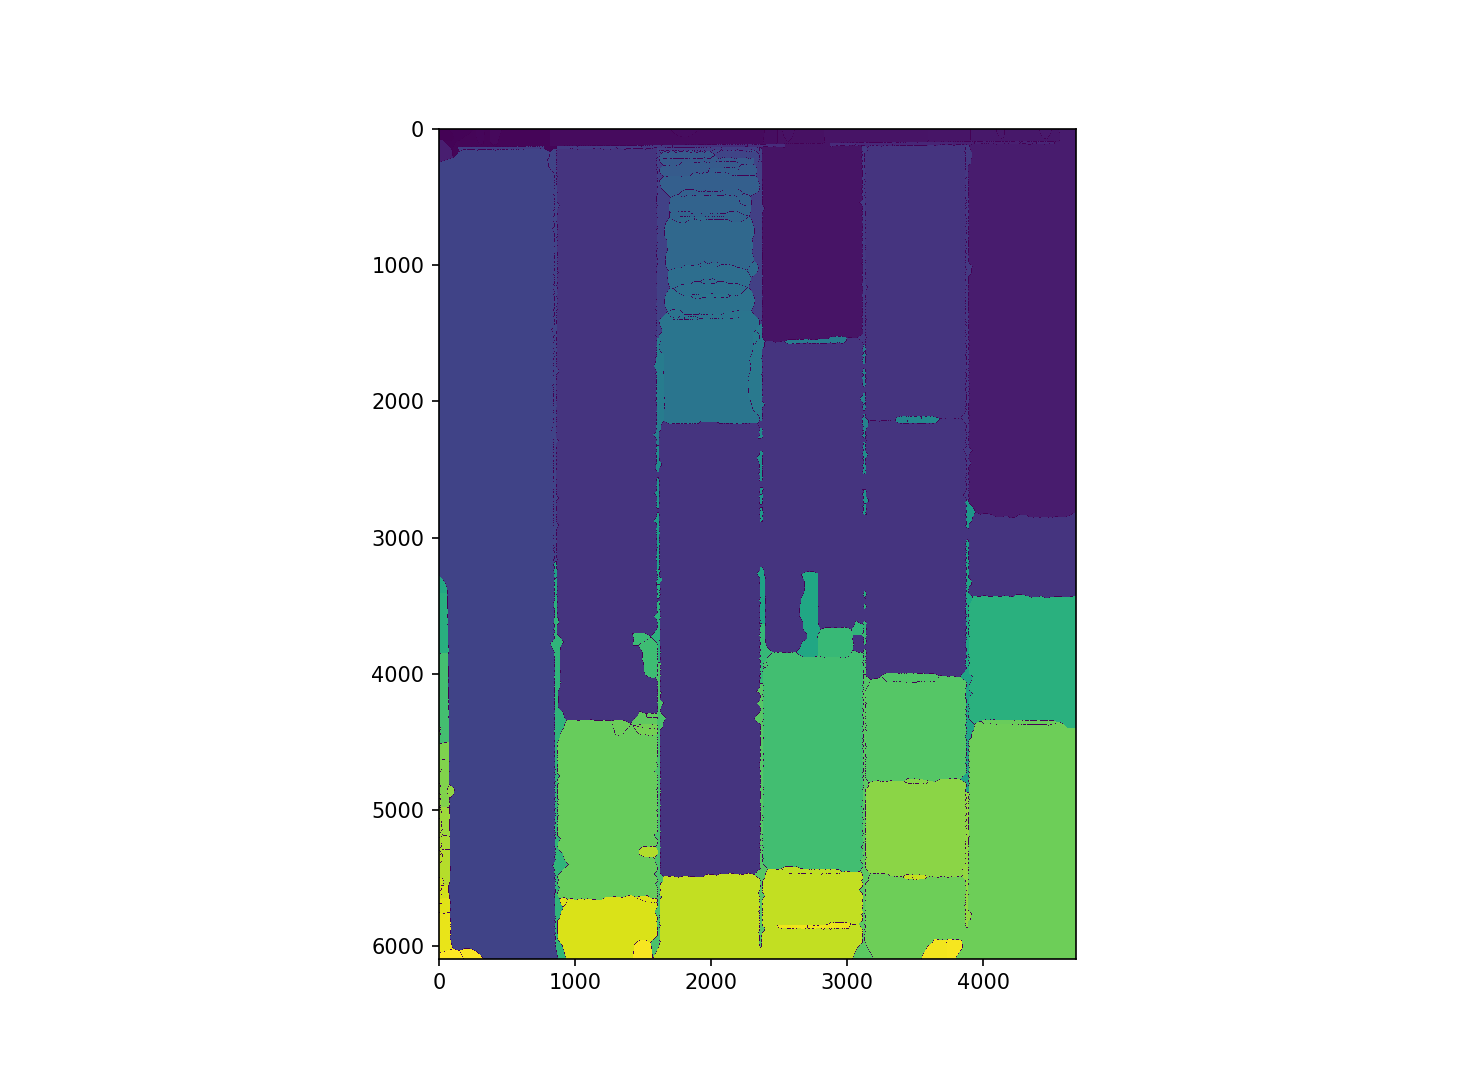

<function matplotlib.pyplot.imshow>

In [5]:
# Voronoi mask analysis
count,label,stat,centroids=cv2.connectedComponentsWithStats((img_voronoi_mask).astype(np.uint8))
print("Total %d region(s) are found." % count)

plt.imshow(label)
plt.imshow

# Generate Binary Connected-component Centroid Mask

38007it [00:00, 218749.32it/s]


<IPython.core.display.Javascript object>


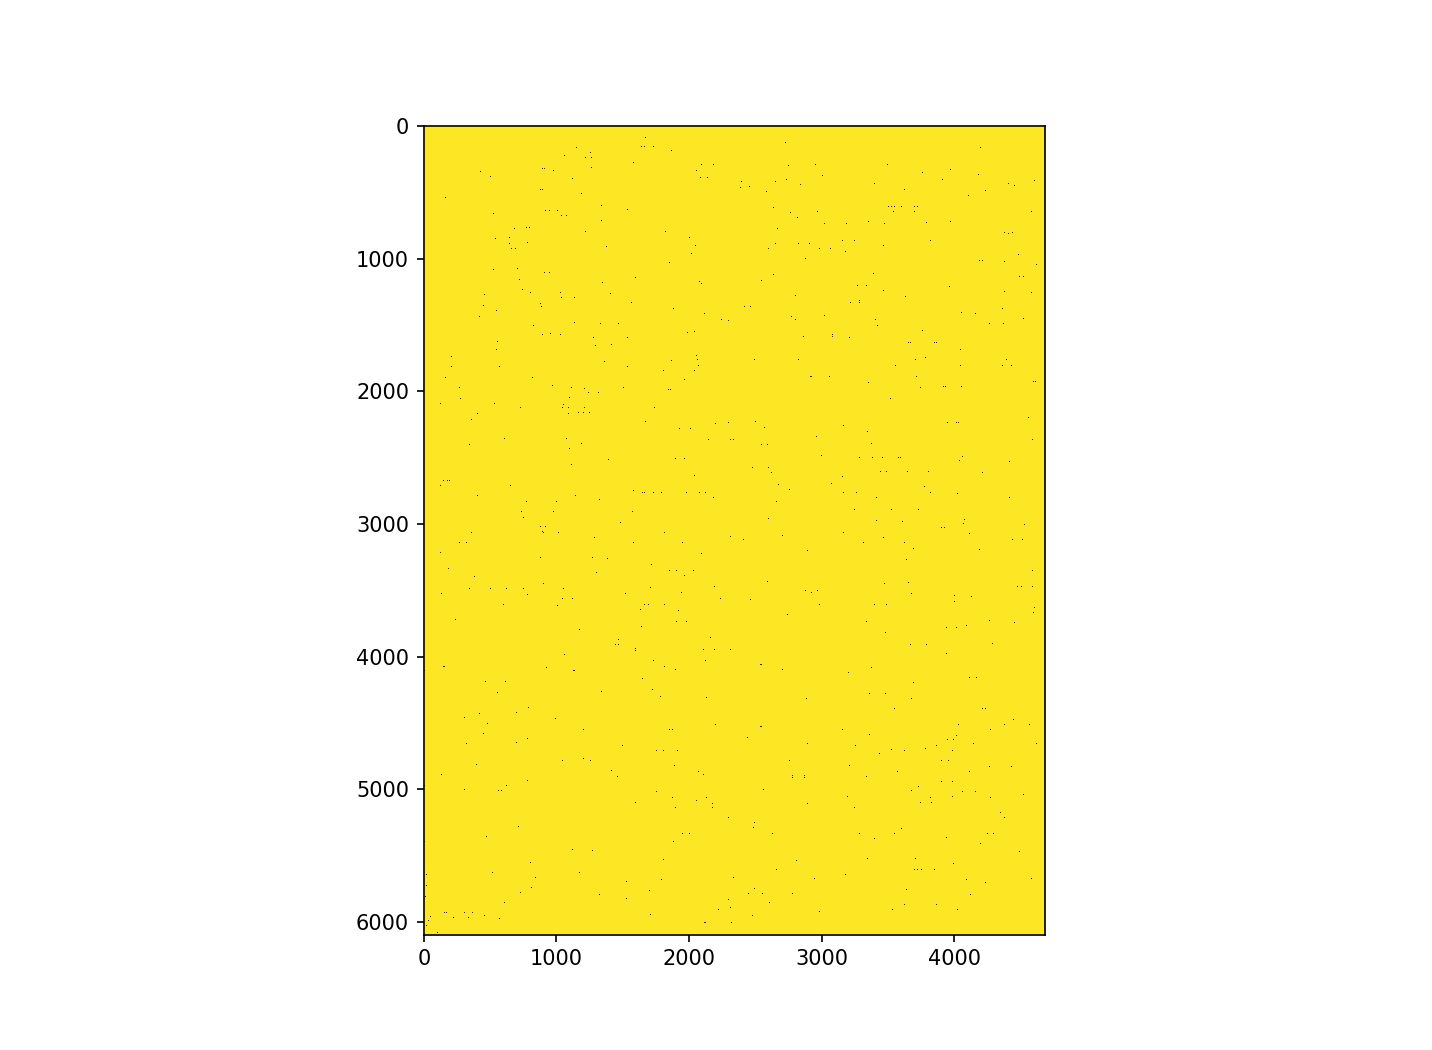

In [6]:
# read cc info
file_ccs = open(os.path.join(ccs_location,in_cc_name),"r")

# cc mask
area_minus_cc_mask = np.copy(stat[:,4])
img_cc_mask = 255*np.ones([h,w])
for line in tqdm(file_ccs): 
    # Parse coordinates
    c,r = (int(x) for x in line.split())
    img_cc_mask[r,c]=0
    #print("({},{})".format(r,c))
    area_minus_cc_mask[label[r,c]]-=1

    
plt.imshow(img_cc_mask)
plt.show()


# Combine (bitwise-and) BVM and BCM

Note that from this mask, we can get an idea the number of connected-components (characters or noises) residing inside of each zone.

<IPython.core.display.Javascript object>


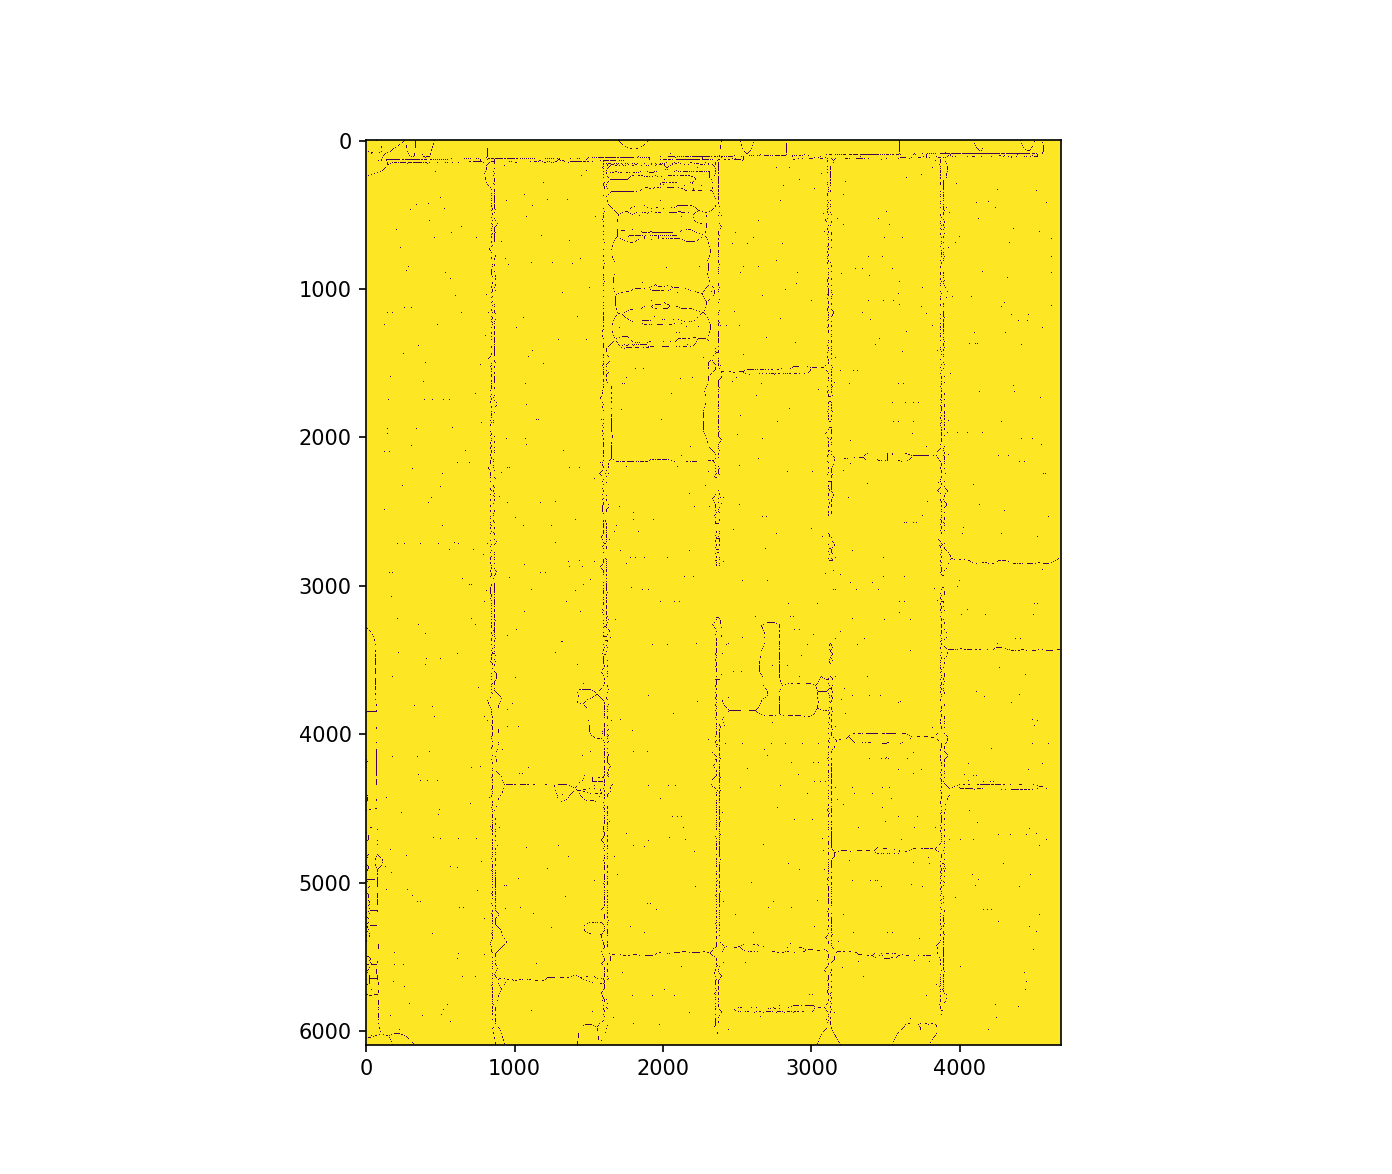

In [7]:
# Combine voronoi mask and cc mask

img_comb = cv2.bitwise_and(img_voronoi_mask,img_cc_mask)
plt.imshow(img_comb)
plt.show()

# Analyze each Zone

In this process, each zone is inspected whether it has more than the specified number of connected-components (**CC_THRESHOLD**). If not, it is considered as noise zone.

In [17]:
# Find regions containing single cc
CC_THRESHOLD = 5
"""
num_of_noise_zone = 0
count_comb,label_comb,stat_comb,centroids_comb=cv2.connectedComponentsWithStats((img_comb).astype(np.uint8))
if count_comb!=count: # or use assert?
    print("Unexpected error has occurred.")
else:
    for i in range(count):
        area_diff = stat[i][4]-stat_comb[i][4]
        if(area_diff<=CC_THRESHOLD):
            num_of_noise_zone+=1
"""

num_of_noise_zone = len(np.argwhere(stat[:,4]-area_minus_cc_mask<=CC_THRESHOLD))

print("Total %d zone(s) are found." % count)
print("Total %d noise zone(s) are found.\n" % num_of_noise_zone)
#stat[1]

Total 206 zone(s) are found.
Total 147 noise zone(s) are found.



# Append Metadata

In [ ]:
# Build JSON
json_metadata['numOfZone']      = str(count)
json_metadata['numOfNoiseZone'] = str(num_of_noise_zone)

zone_area_dist = stat[:,4]

zone_min  = np.min(zone_area_dist)
zone_max  = np.max(zone_area_dist)
zone_mean = int(np.mean(zone_area_dist))
zone_median = np.median(zone_area_dist)
zone_std  = int(np.std(zone_area_dist))

zone_q1  = np.percentile(zone_area_dist, 25)
zone_q3  = np.percentile(zone_area_dist, 75)
zone_iqr = zone_q3-zone_q1

print("min:\t",zone_min)
print("max:\t",zone_max)
print("mean:\t",zone_mean)
print("median:\t",zone_median)
print("std:\t",zone_std)
print("Q1:\t",zone_q1)
print("Q3:\t",zone_q3)
print("IQR:\t",zone_iqr)

print("lb:\t",q1-1.5*iqr)
print("rb:\t",q3+1.5*iqr)



